# Narrative Memory API Demonstration

This notebook demonstrates how to use the `NarrativeMemoryAPI` class defined in `narrative_memory_api.py` to load a fine-tuned Sparse Autoencoder (SAE) and retrieve narrative memories based on neuron activations.

## 1. Import and Initialize the API

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Make sure the API class is importable (it's in the same directory)
# If narrative_memory_api.py is in a different directory, adjust the path or sys.path
try:
    from narrative_memory_api import NarrativeMemoryAPI
except ModuleNotFoundError:
    print("Error: Could not import NarrativeMemoryAPI.")
    print(
        "Ensure 'narrative_memory_api.py' is in the same directory or accessible in the Python path."
    )
    api = None  # Set api to None to prevent errors in subsequent cells

# Initialize the API (this will load model, data, and compute the trace)
if "NarrativeMemoryAPI" in locals():
    try:
        print("Attempting to initialize NarrativeMemoryAPI...")
        api = NarrativeMemoryAPI()
        print("API Initialized successfully.")
    except FileNotFoundError as e:
        print(f"Initialization Error: {e}")
        print(
            "Please ensure 'sae_text_finetuned.pth' and 'synthetic_narrative_data.json' are present in the root directory."
        )
        api = None  # Ensure api is None if initialization fails
    except Exception as e:
        print(f"An unexpected error occurred during initialization: {e}")
        api = None
else:
    print("Skipping API initialization due to import error.")

/Users/leonvanbokhorst/sparse-memory-encoding/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Attempting to initialize NarrativeMemoryAPI...
--- Initializing Narrative Memory API --- 
MPS device found. Using MPS.
Loading narrative data from: synthetic_narrative_data.json...
Loaded 1500 narrative entries.
Loading sentence transformer: all-MiniLM-L6-v2...
Sentence transformer loaded.
Loading fine-tuned SAE model from: sae_text_finetuned.pth...
SAE Model Structure: Proj [384->300], Enc [300->30]
SAE model loaded successfully.
Computing full memory trace...
Encoding 1500 texts...


Batches: 100%|██████████| 47/47 [00:01<00:00, 35.06it/s]

Calculating activations with SAE model...
Memory trace computation complete.
API Initialized. Memory Trace shape: torch.Size([1500, 30])
-----------------------------------------
API Initialized successfully.


## 2. Basic Retrieval: Top Memories for Specific Neurons

Here, we use the API to retrieve memories that most strongly activate our key neurons identified previously.

In [2]:
# Check if API initialized successfully before proceeding
if api:
    # Define key neurons based on our previous analysis
    NEURON_16_INDEX = 16  # Personal Distress Specialist
    NEURON_10_INDEX = 10  # Emotional Intensity & Crisis Indicator
    TOP_K = 5

    # Retrieve for Neuron 16
    print(
        f"--- Top {TOP_K} Memories for Neuron {NEURON_16_INDEX} (Personal Distress) ---"
    )
    n16_indices, n16_vals = api.retrieve_top_k_memories(
        neuron_index=NEURON_16_INDEX, k=TOP_K
    )
    if n16_indices.numel() > 0:
        for i, idx in enumerate(n16_indices):
            print(
                f"  - Score: {n16_vals[i]:.4f}, Index: {idx.item()}: {api.get_narrative_text(idx.item())[:100]}..."
            )
    else:
        print("  (No results found)")

    # Retrieve for Neuron 10
    print(
        f"\n--- Top {TOP_K} Memories for Neuron {NEURON_10_INDEX} (Intensity/Crisis) ---"
    )
    n10_indices, n10_vals = api.retrieve_top_k_memories(
        neuron_index=NEURON_10_INDEX, k=TOP_K
    )
    if n10_indices.numel() > 0:
        for i, idx in enumerate(n10_indices):
            print(
                f"  - Score: {n10_vals[i]:.4f}, Index: {idx.item()}: {api.get_narrative_text(idx.item())[:100]}..."
            )
    else:
        print("  (No results found)")
else:
    print("API not initialized. Skipping retrieval.")

--- Top 5 Memories for Neuron 16 (Personal Distress) ---

Retrieving top 5 for Neuron 16...
  - Score: 1.4970, Index: 46: She trembled uncontrollably as tears streamed down her face, clutching the letter that revealed her ...
  - Score: 1.4235, Index: 209: She clung to her father's hand, tears streaming down her face as he was deployed overseas, feeling a...
  - Score: 1.4099, Index: 341: She clutched the letter close to her chest, tears streaming down her face as she read the words that...
  - Score: 1.3992, Index: 253: She clung to her grandmother's worn quilt, tears streaming down her face as memories flooded back....
  - Score: 1.3947, Index: 42: She clung to his hand, tears streaming down her face as she whispered goodbye, her heart breaking wi...

--- Top 5 Memories for Neuron 10 (Intensity/Crisis) ---

Retrieving top 5 for Neuron 10...
  - Score: 0.6880, Index: 46: She trembled uncontrollably as tears streamed down her face, clutching the letter that revealed her ...
  - Score: 

## 3. Composite Retrieval: Nuanced Queries

Now we demonstrate the more sophisticated composite queries using the API methods.

In [3]:
if api:
    # Query 1: Personal Distress without External Crisis (High N16, Low N10)
    print(
        f"\n--- Top {TOP_K} Memories for High N16 / Low N10 (Personal Distress Focus) ---"
    )
    p16_n10_indices, p16_n10_scores = api.retrieve_memories_composite(
        positive_neurons=[NEURON_16_INDEX], negative_neurons=[NEURON_10_INDEX], k=TOP_K
    )
    if p16_n10_indices.numel() > 0:
        for i, idx in enumerate(p16_n10_indices):
            print(
                f"  - Score: {p16_n10_scores[i]:.4f}, Index: {idx.item()}: {api.get_narrative_text(idx.item())[:100]}..."
            )
    else:
        print("  (No results found)")

    # Query 2: Refined External Crisis (High N10 > threshold, penalized by N16)
    print(
        f"\n--- Top {TOP_K} Memories for Refined External Crisis (N10 >= 0.5, penalized N16) ---"
    )
    crisis_indices, crisis_scores = api.retrieve_external_crisis(k=TOP_K)
    if crisis_indices.numel() > 0:
        for i, idx in enumerate(crisis_indices):
            print(
                f"  - Score: {crisis_scores[i]:.4f}, Index: {idx.item()}: {api.get_narrative_text(idx.item())[:100]}..."
            )
    else:
        print("  (No results found)")

    # Query 3: Routine Focus (Low N10 and Low N16)
    print(f"\n--- Top {TOP_K} Memories for Low N10 & Low N16 (Routine Focus) ---")
    routine_indices, routine_scores = api.retrieve_memories_composite(
        positive_neurons=[],
        negative_neurons=[NEURON_10_INDEX, NEURON_16_INDEX],
        k=TOP_K,
    )
    if routine_indices.numel() > 0:
        for i, idx in enumerate(routine_indices):
            print(
                f"  - Score: {routine_scores[i]:.4f}, Index: {idx.item()}: {api.get_narrative_text(idx.item())[:100]}..."
            )
    else:
        print("  (No results found)")
else:
    print("API not initialized. Skipping composite retrieval.")


--- Top 5 Memories for High N16 / Low N10 (Personal Distress Focus) ---

Retrieving top 5 composite: Pos=[16], Neg=[10]...
  - Score: 0.8461, Index: 620: A busy airport terminal erupts into chaos as multiple flights are suddenly canceled, passengers rush...
  - Score: 0.8447, Index: 205: She burst into tears upon hearing the news of her grandmother's passing, her trembling hands betrayi...
  - Score: 0.8422, Index: 410: She broke down crying as she read the heartfelt letter, feeling the overwhelming surge of love and s...
  - Score: 0.8418, Index: 15: She clung to her grandmother's hand, tears streaming down her face as they said goodbye, feeling a m...
  - Score: 0.8400, Index: 321: She clung to her grandmother's hand, tears streaming down her face as she said goodbye, feeling her ...

--- Top 5 Memories for Refined External Crisis (N10 >= 0.5, penalized N16) ---

Retrieving top 5 refined external crisis (N10>=0.5, penalized by N16)...
Found 36 memories with Neuron 10 >= 0.5
  - Scor

## 4. Visualization using API Data

We can fetch the memory trace directly from the API object and use it for visualization, similar to our previous analysis script.


Performing PCA for visualization...
PCA complete.


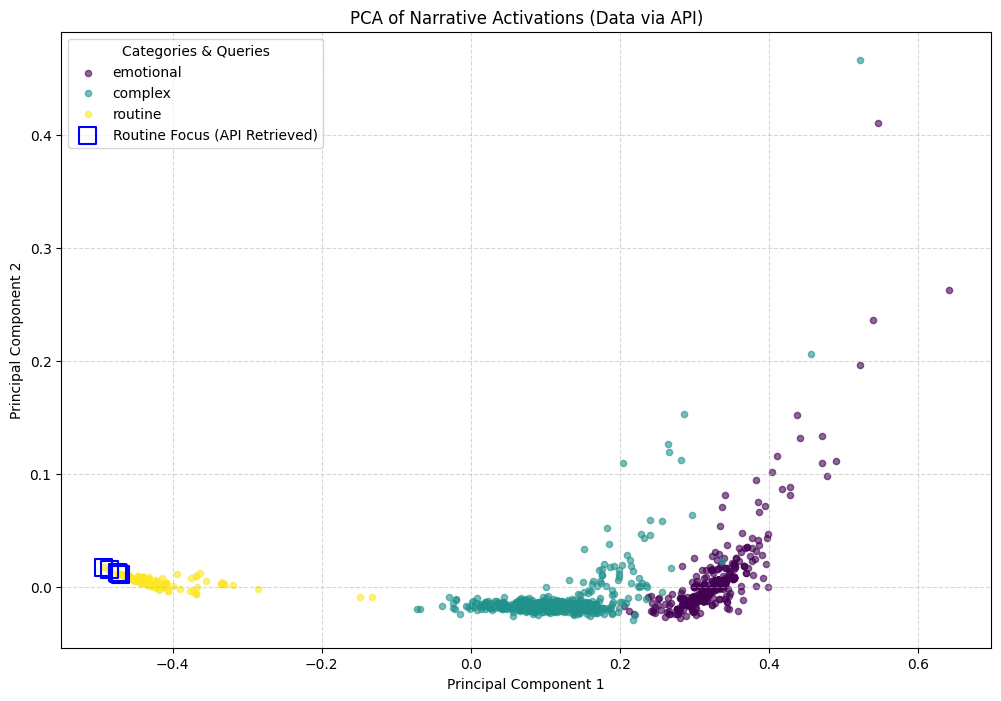

In [4]:
if api:
    # Get the full memory trace from the API
    memory_trace = api.memory_trace  # Access the precomputed trace

    # Get category information (assuming structure from original script)
    CATEGORIES = ["emotional", "complex", "routine"]
    category_map = {name: i for i, name in enumerate(CATEGORIES)}
    # Need to reconstruct category_indices if not stored in API (could be added to API)
    try:
        category_names = [item["category"] for item in api.narratives]
        category_indices = torch.tensor(
            [category_map[name] for name in category_names]
        ).long()

        # Perform PCA
        print("\nPerforming PCA for visualization...")
        pca = PCA(n_components=2)
        memory_trace_np = memory_trace.numpy()
        pca_result = pca.fit_transform(memory_trace_np)
        print("PCA complete.")

        # Plotting
        plt.figure(figsize=(12, 8))
        scatter_handles = []
        colors = plt.cm.viridis(np.linspace(0, 1, len(CATEGORIES)))

        for i, category_name in enumerate(CATEGORIES):
            category_mask = category_indices == category_map[category_name]
            scatter = plt.scatter(
                pca_result[category_mask, 0],
                pca_result[category_mask, 1],
                color=colors[i],
                label=category_name,
                alpha=0.6,
                s=20,
            )
            scatter_handles.append(scatter)

        # --- Highlight Retrieved Points (Example: Routine Focus using 'routine_indices' from cell above) ---
        # Ensure routine_indices exists and is not empty before trying to highlight
        if "routine_indices" in locals() and routine_indices.numel() > 0:
            highlight_indices_list = routine_indices.tolist()
            # Check if indices are within bounds
            valid_highlight_indices = [
                idx for idx in highlight_indices_list if idx < len(pca_result)
            ]
            if valid_highlight_indices:
                h_scatter = plt.scatter(
                    pca_result[valid_highlight_indices, 0],
                    pca_result[valid_highlight_indices, 1],
                    marker="s",
                    s=150,
                    edgecolor="blue",
                    facecolor="none",
                    linewidth=1.5,
                    label="Routine Focus (API Retrieved)",
                )
                scatter_handles.append(h_scatter)
            else:
                print("Warning: Routine indices were out of bounds for plotting.")
        else:
            print("Warning: 'routine_indices' not available for highlighting.")

        plt.title("PCA of Narrative Activations (Data via API)")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend(handles=scatter_handles, title="Categories & Queries")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    except Exception as e:
        print(f"An error occurred during visualization: {e}")

else:
    print("API not initialized. Skipping visualization.")

## 5. Conclusion

The `NarrativeMemoryAPI` provides a convenient way to load the necessary components and perform sophisticated, neuron-based retrieval on the narrative dataset. This notebook demonstrates its core functionalities.